Importo las librerias que voy a usar

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import datetime as dt

Utilizo la libreria :pandas para comvertir el csv en un dataframe y combierto el campo Date a un formato legible para la reguesion lineal

In [5]:
train = pd.read_csv('train.csv', sep = ',')

train['Date'] = pd.to_datetime(train['Date'])
train['Date']=train['Date'].map(dt.datetime.toordinal)

Visualizo el dataframe para ver que todo esta bien

In [6]:
train.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,727931,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,727932,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,727933,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,727934,NaN,NaN,NaN,NaN,NaN,NaN,0
4,727935,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
95,728064,3593.399902,3626.600098,3593.399902,3622.600098,3622.596436,0.0,1
96,728065,3622.600098,3629.199951,3595.500000,3626.199951,3626.196289,0.0,1
97,728066,3642.199951,3677.300049,3642.199951,3646.000000,3645.996338,0.0,1
98,728067,3643.399902,3643.399902,3613.899902,3626.300049,3626.296387,0.0,1


Realizo un conteo de todos los tatos y cuantos nulos tengo para valorar mi sigueinte paso.

In [7]:
train.count()

Date         6554
Open         6421
High         6421
Low          6421
Close        6421
Adj Close    6421
Volume       6421
Target       6554
dtype: int64

In [8]:
train.isnull().sum()

Date           0
Open         133
High         133
Low          133
Close        133
Adj Close    133
Volume       133
Target         0
dtype: int64

Podemos observar que se han detectado 133 filas completamente vacias a falta de fecha y target, por lo tanto se deben eliminar todos esos datos que pueden sesgar nuestro modelo.

In [9]:
train = train.dropna()

Comprobamos si se han eliminado todos los nulos

In [10]:
train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Target       0
dtype: int64

Ahora ya tenemos el dataframe perfecto para crear un modelo predictivo supervisado.

Primero nos quedaremos con un 80% del total de datos elegidos aleatoriamente para realizar el modelo y  el 20% restante sera para ver como de bien o mal realiza las prediciones.

In [11]:
trainSplit = train.sample(frac=0.8,random_state=0)
test = train.drop(trainSplit.index)

Ahora vamos a visualizar unos graficos para entender mejor el dataset y observar que tipo de modelo es el mas optimo.

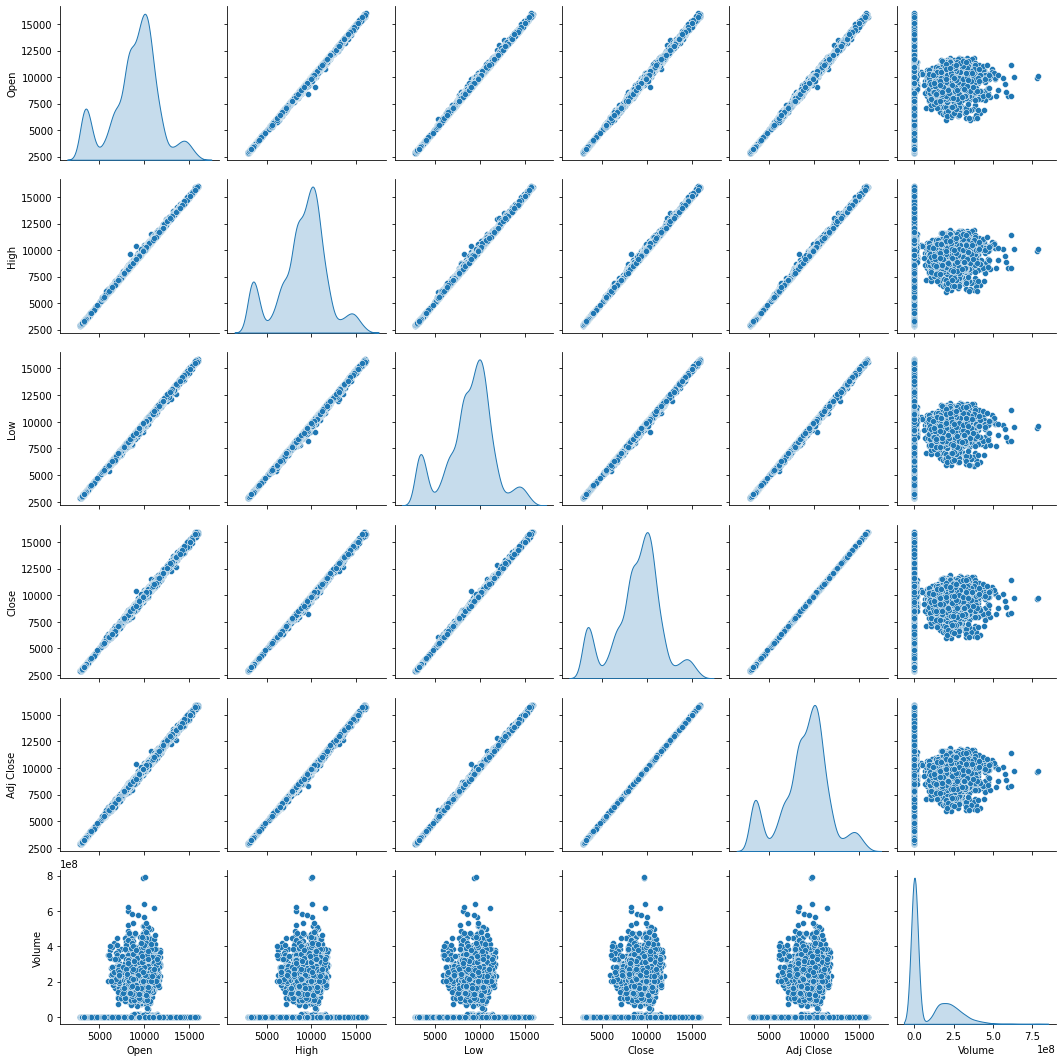

In [12]:
sns.pairplot(trainSplit[["Open", "High", "Low", "Close", "Adj Close", "Volume"]], diag_kind="kde")

Separamos el target del resto de variables

In [13]:
train_labels = trainSplit.pop('Target')
test_labels = test.pop('Target')

definimos la funcion encargada de la creacion del modelo

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(trainSplit.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  trainSplit, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.249226,0.498054,0.249226,0.250910,0.499297,0.250910,995
996,0.249193,0.497819,0.249193,0.250102,0.499613,0.250102,996
997,0.249228,0.498181,0.249228,0.250344,0.499488,0.250344,997
998,0.249151,0.497935,0.249151,0.250278,0.499517,0.250278,998
999,0.249166,0.498245,0.249166,0.251428,0.499167,0.251428,999


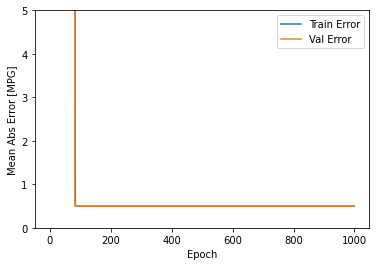

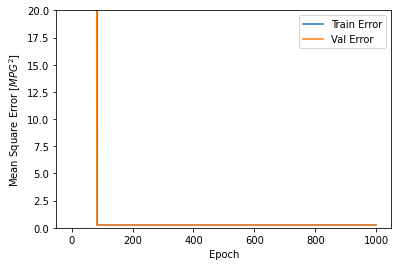

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.............

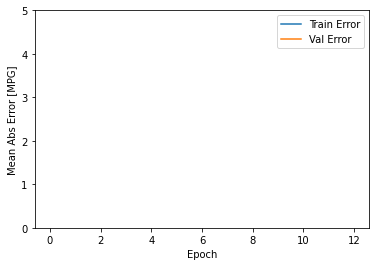

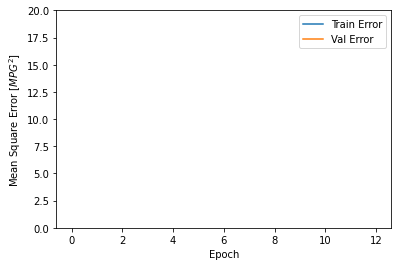

In [20]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(trainSplit, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)